Reminders:

Since the grades are classified using numbers 1-20, we should check for inbalances (i.e. if there's only one 17)

The final report consists of a model, as well as intpreting what the accuracy could mean

https://raw.githubusercontent.com/edsters78/Project_Proposal/main/student-mat.csv <br> 
This is the link to the data set we are using.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(scales)
#library(dplyr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

# Predicting a Student's Success

## Introduction

In [2]:
#reading data from web
options(repr.matrix.max.rows = 10)
url<-"https://raw.githubusercontent.com/edsters78/Project_Proposal/main/student-mat.csv"
student_data<-read_csv(url)
#student_data

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



In [3]:
#tidying the data
#selecting only the variables that will be most relevant
student_data_clean <- student_data %>%
    select(sex, address, Medu, Fedu, traveltime, studytime, paid, activities, internet, famrel, Dalc, Walc, health, absences, G3) 
#student_data_clean

student_data_clean_nonly <- student_data_clean %>%
    mutate(sex = ifelse(sex == "F", 1, 0), #1 is female, 0 is male
          address = ifelse(address == "U", 1, 0), #1 is Urban, 0 is Rural
          paid = ifelse(paid == "yes", 1, 0), #1 is yes, 0 is no
          activities = ifelse(activities == "yes", 1, 0), #1 is yes, 0 is no
          internet = ifelse(internet == "yes", 1, 0)) #1 is yes, 0 is no
student_data_clean_nonly

sex,address,Medu,Fedu,traveltime,studytime,paid,activities,internet,famrel,Dalc,Walc,health,absences,G3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,4,4,2,2,0,0,0,4,1,1,3,6,6
1,1,1,1,1,2,0,0,1,5,1,1,3,4,6
1,1,1,1,1,2,1,0,1,4,2,3,3,10,10
1,1,4,2,1,3,1,1,1,3,1,1,5,2,15
1,1,3,3,1,2,1,0,0,4,1,2,5,4,10
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,1,2,2,1,2,1,0,0,5,4,5,4,11,9
0,1,3,1,2,1,0,0,1,2,3,4,2,3,16
0,0,1,1,1,1,0,0,0,5,3,3,3,3,7


In [4]:
#splitting into training and testing data
student_split <- initial_split(student_data_clean_nonly, prop = 0.75, strat = G3)
student_train <- training(student_split)
student_test <- testing(student_split)

student_train
#student_test

sex,address,Medu,Fedu,traveltime,studytime,paid,activities,internet,famrel,Dalc,Walc,health,absences,G3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,1,1,2,0,0,1,5,1,1,3,4,6
1,1,1,1,1,2,1,0,1,4,2,3,3,10,10
1,1,4,2,1,3,1,1,1,3,1,1,5,2,15
1,1,3,3,1,2,1,0,0,4,1,2,5,4,10
0,1,4,3,1,2,1,1,1,5,1,2,5,10,15
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,1,2,2,1,2,1,0,0,5,4,5,4,11,9
0,1,3,1,2,1,0,0,1,2,3,4,2,3,16
0,0,1,1,1,1,0,0,0,5,3,3,3,3,7


`summarise()` ungrouping output (override with `.groups` argument)



G3,n
<dbl>,<int>
0,38
4,1
5,7
6,15
7,9
⋮,⋮
16,16
17,6
18,12


G3,n
<dbl>,<int>
4,1
20,1
19,5
17,6
5,7
⋮,⋮
8,32
15,33
0,38


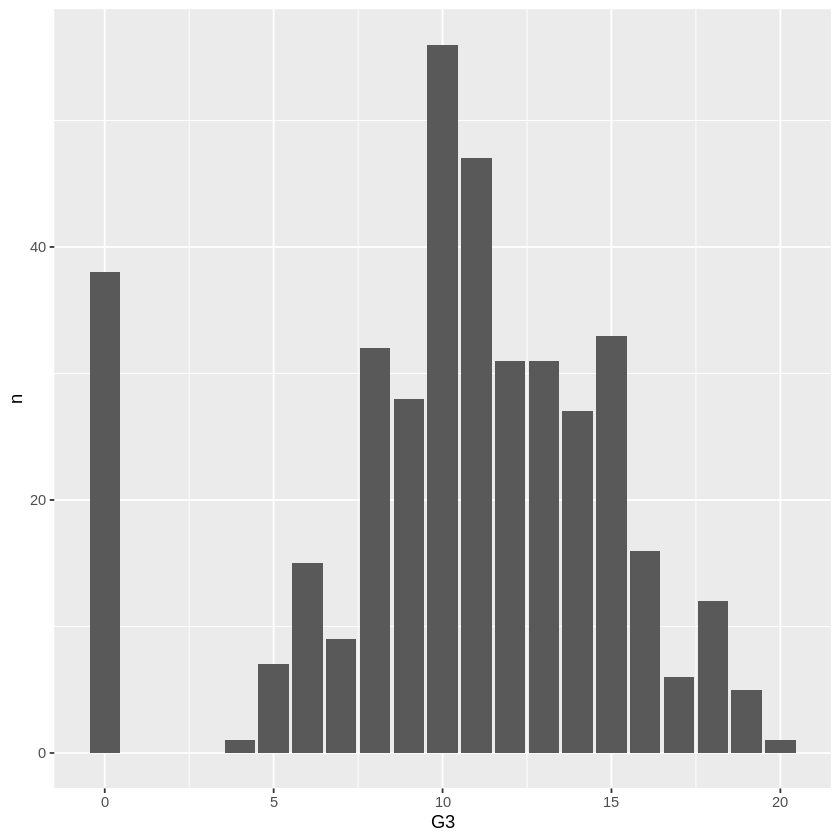

In [5]:
student_G3_count <- student_data %>%
    group_by(G3) %>%
    summarise(n = n())
student_G3_count


student_G3_count_plot <- ggplot(student_G3_count, aes(x = G3, y = n)) +
    geom_bar(stat = "identity")
student_G3_count_plot
        
student_G3_count %>% arrange(n)